<a href="https://colab.research.google.com/github/jdtoscano94/Learning-PINNs-in-Python-Physics-Informed-Machine-Learning/blob/main/6_BurgersEquation(Inverse).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [262]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io

import optuna
import logging
import sys

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cpu


# Tunning Parameters

In [263]:
# steps=20000
# lr=1e-1
# layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
N_u = 100 #Total number of data points for 'u'
N_f = 10_000 #Total number of collocation points 
nu = 0.01/np.pi #diffusion coefficient

# Auxiliary Functions


In [264]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [265]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [266]:
def solutionplot(u_pred,X_u_train,u_train):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 0.5, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.25s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75s$', fontsize = 10)
    
    plt.savefig('Burgers-Inverse.png',dpi = 500)   

# Problem Setup
https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks

**Burgers' Equation**

$$\frac{\partial u}{\partial t}+ \lambda_1u\frac{\partial u}{\partial x}=\lambda_2\frac{\partial^2 u}{\partial x^2} $$

$$x\in[-1,1]$$
$$t\in[0,1]$$


# Inverse Problems

**Forward Problem**: Model$→$Data (Predict)

**Inverse Problem**: Data→Model (i.e., actually, we get the Model's parameters)

###Example

(See: https://book.sciml.ai/notes/10/)

A Neural Network is an example of an inverse problem:

1.   We have an unknown model that follows:

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

2.   We use our "training" data to get $W_i$ and $b_i$; for $i=1,2,..\#layers$.


Specifically:

Data → Model i.e., estimate our model parameters (i,e., $W_i$ and $b_i$)




# PINNs for Inverse Problems or "Data-driven Discovery of Nonlinear Partial Differential Equations"

(See: https://arxiv.org/abs/1711.10566)

**Inverse Problem**: Data$→$Model's parameters so:

Data →PINN→ Model Parameters (i.e., our PDE parameters)

For parameterized and nonlinear partial differential equations of the general form (Raissi et al., 2017):

$$u_t+\mathscr{N}[u;\lambda]=0$$

where, $u(x,t)$ is the hidden solution and $\mathscr{N}[;\lambda]$ is a nonlinear operator parameterized by $\lambda$.

In short: We will use a PINN to get $\lambda$.


## Analysis:

Let:

$u_t=\frac{\partial u}{\partial t}$

$u_x=\frac{\partial u}{\partial x}$

$u_{xx}=\frac{\partial^2 u}{\partial x^2}$

$\mathscr{N}[u;\lambda]=\lambda_1u u_x-\lambda_2 u_{xx}$

Our PDE is described as:

$$u_t+\lambda_1uu_x=\lambda_2u_{xx}$$

If we rearrange our PDE, we get:

$$u_t+\lambda_1uu_x-\lambda_2 u_{xx}=0$$

Or,

$$u_t+\mathscr{N}[u;\lambda]=0$$

So we can use a PINN to obtain $\lambda$!

In our case (from the reference solution) $\lambda=[\lambda_1,\lambda_2]=[1,\nu]=\left[1,\frac{1}{100\pi}\right]$













## Neural Network

A Neural Network is a function (See:https://book.sciml.ai/notes/03/):

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

**Note:**We usually train our N by iteratively minimizing a loss function in the training dataset(known data) to get $W_i$ and $b_i$.
 
## PINNs=Neural Network + PDE 
(See: https://www.sciencedirect.com/science/article/pii/S0021999118307125)

We can use a neural network to approximate any function (Universal APproximation Theorem): (See:https://book.sciml.ai/notes/03/)
$$N(x,t)\approx u(x,t)$$ 

Since N(x,t) is a function, we can obtain its derivatives: $\frac{\partial N}{\partial t},\frac{\partial^2 N}{\partial x^2}, etc.$.(Automatic Diferentiation) 

Assume:$$N(t,x)\approx u(t,x)$$ 

Then:

$$N_t+\lambda_1NN_x-\lambda_2 N_{xx}\approx u_t+uu_x-\lambda u_{xx}=0$$

And:

$$N_t+\lambda_1NN_x-\lambda_2 N_{xx}\approx 0$$


We define this function as $f$:

$$f(t,x)=N_t+\lambda_1NN_x-\lambda_2N_{xx}$$

Remember our operator:

$$f(t,x)=N_t+\mathscr{N}[N,\lambda]$$

So:

$$f(t,x)\approx 0$$

### PINNs' Loss function

We evaluate $f$ in a certain number of points ($N_u$) inside our domain $(x,t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{N_u}\sum^{N_u}_{i=1}|f(t_u^i,x_u^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, points inside our domain (i.e., interior points). **Remember that this is an inverse problem, so we know the data.**

Since we know the outcome, we select $N$ and compute the $MSE_u$** (compare it to the reference solution).

$$MSE_{u}=\frac{1}{N_u}\sum^{N_u}_{i=1}|u(t_{u}^i,x_u^i)-N(t_{u}^i,x_u^i)|^2$$

Please note that $\{t_u^i,x_u^i\}_{i=1}^N$ are the same in $MSE_f$ and $MSE_u$

#### Total Loss:

$$MSE=MSE_{u}+MSE_f$$

NOTE: We minimize $MSE$ to obtain the $N$'s parameters (i.e, $W_i$ and $b_i$) and the ODE parameters (i.e., $\lambda$)→ We will ask our neural network to find our $\lambda$.

### Neural Network

In [267]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self, layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
        self.layers = layers
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(self.layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a

## Initialize our parameters

Our operator is:

$$\mathscr{N}[u;\lambda]=\lambda_1u u_x-\lambda_2 u_{xx}$$

We know that:

$$\lambda_1=1$$

$$\lambda_2=\nu=\frac{1}{100\pi}=0.003183$$

In [268]:
lambda1=2.0
lambda2=0.2
print("Te real 𝜆 = [", 1.0,nu,"]. Our initial guess will be 𝜆 _PINN= [",lambda1,lambda2,"]")

Te real 𝜆 = [ 1.0 0.003183098861837907 ]. Our initial guess will be 𝜆 _PINN= [ 2.0 0.2 ]


In [269]:
#  PINN

#https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics

class FCN():
    def __init__(self, layers, optimizer=None):
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialize iterator'
        self.iter = 0
        self.layers = layers
        self.optimizer = optimizer
        print(f"Layers: {layers}")
        'Initialize our new parameters i.e. 𝜆 (Inverse problem)' 
        self.lambda1 = torch.tensor([lambda1], requires_grad=True).float().to(device)  
        self.lambda2 = torch.tensor([lambda2], requires_grad=True).float().to(device)  
        'Register lambda to optimize'
        self.lambda1 = nn.Parameter(self.lambda1)
        self.lambda2 = nn.Parameter(self.lambda2)
        'Call our DNN'
        self.dnn = DNN(layers).to(device)
        'Register our new parameter'
        self.dnn.register_parameter('lambda1', self.lambda1)  
        self.dnn.register_parameter('lambda2', self.lambda2)                                                           
        'loss function'
            
    def loss_data(self,x,y):
                
        loss_u = self.loss_function(self.dnn(x), y)
      
        return loss_u
    
    def loss_PDE(self, X_train_Nu):
                        
        lambda1=self.lambda1

        lambda2=self.lambda2

        g = X_train_Nu.clone()
                        
        g.requires_grad = True
        
        u = self.dnn(g)
                
        u_x_t = autograd.grad(u,g,torch.ones([X_train_Nu.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(X_train_Nu.shape).to(device), create_graph=True)[0]
                                                            
        u_x = u_x_t[:,[0]]
        
        u_t = u_x_t[:,[1]]
        
        u_xx = u_xx_tt[:,[0]]
                                        
        f = u_t + (lambda1)*(self.dnn(g))*(u_x) - (lambda2)*u_xx 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,x,y):

        loss_u = self.loss_data(x,y)
        loss_f = self.loss_PDE(x)
        
        loss_val = loss_u + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        self.optimizer.zero_grad()
        
        loss = self.loss(X_train_Nu, U_train_Nu)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:

            error_vec, _ = self.test()
        
            print(
                'Relative Error(Test): %.5f , 𝜆_real = [1.0,  %.5f], 𝜆_PINN = [%.5f,  %.5f]' %
                (
                    error_vec.cpu().detach().numpy(),
                    nu,
                    self.lambda1.item(),
                    self.lambda2.item()
                )
            )
            

        return loss        
    
    'test neural network'
    def test(self):
                
        u_pred = self.dnn(X_true)
        
        error_vec = torch.linalg.norm((U_true-u_pred),2)/torch.linalg.norm(U_true,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = u_pred.cpu().detach().numpy()
        
        u_pred = np.reshape(u_pred,(x.shape[0],t.shape[0]),order='F')
                
        return error_vec, u_pred
        
    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

# Visualize data

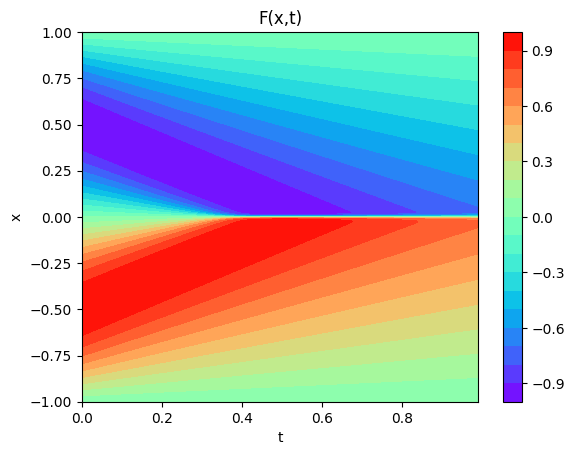

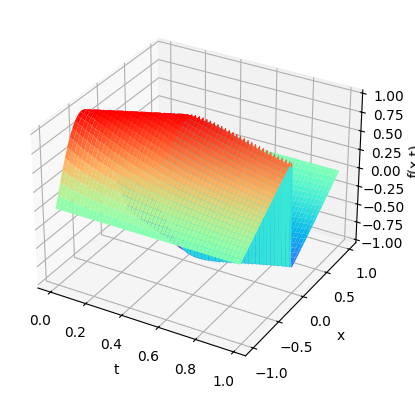

In [270]:
data = scipy.io.loadmat('../../Data/Burgers.mat') 
x = data['x']                                   # 256 points between -1 and 1 [256x1]
t = data['t']                                   # 100 time points between 0 and 1 [100x1] 
usol = data['usol']                             # solution of 256x100 grid points

X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol)) 

In [271]:
print(x.shape,t.shape,usol.shape)
print(X.shape,T.shape)

(256, 1) (100, 1) (256, 100)
(100, 256) (100, 256)


## Prepare Data

In [272]:
X_true = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_true[0]  # [-1. 0.]
ub = X_true[-1] # [1.  0.99]
U_true = usol.flatten('F')[:,None] #Fortran style (Column Major)

In [273]:
print(lb,ub)

[-1.  0.] [1.   0.99]


## Training Data

In [274]:
total_points=len(x)*len(t)

In [275]:
# Obtain random points for interior
id_f = np.random.choice(total_points, N_f, replace=False)# Randomly chosen points for Interior
X_train_Nu = X_true[id_f]
U_train_Nu= U_true[id_f]

In [276]:
print("We have",total_points,"points. We will select",X_train_Nu.shape[0],"points to train our model.")


We have 25600 points. We will select 10000 points to train our model.


In [277]:
print("Original shapes for X and U:",X.shape,usol.shape)
print("Final training data:",X_train_Nu.shape,U_train_Nu.shape)

Original shapes for X and U: (100, 256) (256, 100)
Final training data: (10000, 2) (10000, 1)


# Train Neural Network

In [278]:
# 'Convert our arrays to tensors and send them to our GPU'
# X_train_Nu = torch.from_numpy(X_train_Nu).float().to(device)
# U_train_Nu = torch.from_numpy(U_train_Nu).float().to(device)
# X_true = torch.from_numpy(X_true).float().to(device)
# U_true = torch.from_numpy(U_true).float().to(device)
# f_hat = torch.zeros(X_train_Nu.shape[0],1).to(device)

In [279]:
def ensure_tensor(x, device):
    if not torch.is_tensor(x):
        return torch.from_numpy(x).float().to(device)
    return x.float().to(device)

# Use the function for conversions
# X_train_Nf = ensure_tensor(X_train_Nf, device)
X_train_Nu = ensure_tensor(X_train_Nu, device)
U_train_Nu = ensure_tensor(U_train_Nu, device)
X_true = ensure_tensor(X_true, device)
U_true = ensure_tensor(U_true, device)
f_hat = torch.zeros(X_train_Nu.shape[0], 1).to(device)

# Define the objective function

def objective(trial):
    # Hyperparameters to optimize
    lr = trial.suggest_float('lr', 1e-5, 1e-2)
    hidden_layers = trial.suggest_categorical('hidden_layers', [4,6, 8, 16])
    layer_width = trial.suggest_categorical('layer_width', [32, 64, 128])
    steps = trial.suggest_int("steps", 10000, 20000, step=5000)
    

    layers = [2] + [layer_width] * hidden_layers + [1]
    
    # Create PINN with optimized configuration
    PINN = FCN(layers)
    print(PINN)
    params = list(PINN.dnn.parameters())
    

    
    # L-BFGS Optimizer with trial-suggested learning rate
    optimizer = torch.optim.LBFGS(params, 
                                   lr=lr, 
                                   max_iter=steps, 
                                   max_eval = None,
                                   tolerance_grad=1e-11, 
                                   tolerance_change=1e-11, 
                                   history_size=100, 
                                   line_search_fn='strong_wolfe')

    PINN.set_optimizer(optimizer)
    
    # Training
    start_time = time.time()
    optimizer.step(PINN.closure)
    elapsed = time.time() - start_time
    print('Training time: %.2f' % (elapsed))
    
    error_vec, _ = PINN.test()
    print('Test Error: %.5f' % (error_vec))
    
    return error_vec.item()
    

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Print best trial results
print('Best trial:')
trial = study.best_trial
print(f'  Value (Test Error): {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-11-23 00:00:17,751] A new study created in memory with name: no-name-45462a64-38e8-4d1d-9a17-841f76f0515f


Layers: [2, 32, 32, 1]
Relative Error(Test): 0.77989 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [1.21850,  0.40284]
Relative Error(Test): 0.31339 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.04403,  0.00334]
Relative Error(Test): 0.29518 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.06294,  0.00284]
Relative Error(Test): 0.25053 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.28862,  0.00831]
Relative Error(Test): 0.23201 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.42886,  0.01131]
Relative Error(Test): 0.22618 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.45029,  0.01032]
Relative Error(Test): 0.21837 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.49157,  0.00913]
Relative Error(Test): 0.20546 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.54326,  0.00854]
Relative Error(Test): 0.19707 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.62180,  0.00906]
Relative Error(Test): 0.19079 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.67167,  0.00895]
Relative Error(Test): 0.18731 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.70156,  0.00902]
Relative Error(Test)

[I 2024-11-23 00:01:54,687] Trial 0 finished with value: 0.17211157083511353 and parameters: {'lr': 0.005710512920050385, 'hidden_layers': 2, 'layer_width': 32, 'steps': 15000}. Best is trial 0 with value: 0.17211157083511353.


Training time: 96.92
Test Error: 0.17211
Layers: [2, 32, 32, 32, 32, 1]
Relative Error(Test): 0.77813 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.85789,  0.79184]
Relative Error(Test): 0.36886 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.63300,  0.07374]
Relative Error(Test): 0.27637 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.36741,  0.02134]
Relative Error(Test): 0.22575 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.41432,  0.01039]
Relative Error(Test): 0.20987 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.48275,  0.01038]
Relative Error(Test): 0.19231 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.55528,  0.01085]
Relative Error(Test): 0.17677 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.60856,  0.01130]
Relative Error(Test): 0.16202 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.64143,  0.01039]
Relative Error(Test): 0.14913 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.67052,  0.01008]
Relative Error(Test): 0.13309 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.70466,  0.00924]
Relative Error(Test): 0.12984 , 𝜆_real = [1.0,  0.00318], 

[I 2024-11-23 00:06:16,274] Trial 1 finished with value: 0.04963953420519829 and parameters: {'lr': 0.0037869896658739846, 'hidden_layers': 4, 'layer_width': 32, 'steps': 20000}. Best is trial 1 with value: 0.04963953420519829.


Training time: 261.57
Test Error: 0.04964
Best trial:
  Value (Test Error): 0.04963953420519829
  Params: 
    lr: 0.0037869896658739846
    hidden_layers: 4
    layer_width: 32
    steps: 20000


In [282]:
best_layers = [2]
best_layers.extend([trial.params['layer_width']] * trial.params['hidden_layers'])
best_layers.append(1)

final_PINN = FCN(best_layers)
print(final_PINN)

best_steps = trial.params['steps']

best_optimizer = torch.optim.LBFGS(final_PINN.dnn.parameters(), 
                                    lr=trial.params['lr'], 
                                    max_iter=best_steps, 
                                    tolerance_grad=1e-11, 
                                    tolerance_change=1e-11, 
                                    history_size=100, 
                                    line_search_fn='strong_wolfe')


final_PINN.set_optimizer(best_optimizer)
start_time = time.time()
# train final model with best hyperparameters
best_optimizer.step(final_PINN.closure)
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

final_error, final_pred = final_PINN.test()

# print results
print("Best hyperparameters: ", study.best_params)
print("Best test error: ", study.best_value)
print("Final model test error: ", final_error.item())

Layers: [2, 32, 32, 32, 32, 1]
Relative Error(Test): 0.76402 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.78620,  0.69652]
Relative Error(Test): 0.35848 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.22403,  0.03045]
Relative Error(Test): 0.28702 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.21812,  0.01276]
Relative Error(Test): 0.26114 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.27114,  0.00732]
Relative Error(Test): 0.23597 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.27549,  0.00563]
Relative Error(Test): 0.20962 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.41301,  0.00830]
Relative Error(Test): 0.19733 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.49729,  0.00985]
Relative Error(Test): 0.18830 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.51234,  0.00907]
Relative Error(Test): 0.18300 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.53232,  0.00884]
Relative Error(Test): 0.16846 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.62992,  0.00986]
Relative Error(Test): 0.16117 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.66223,  0.01140]
Relative Err

# Plots

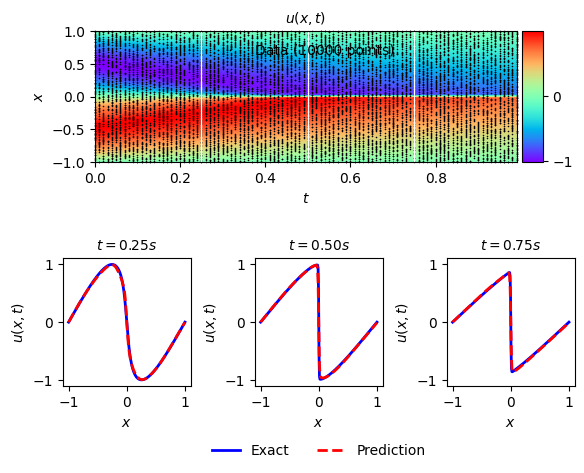

In [284]:
solutionplot(final_pred,X_train_Nu.cpu().detach().numpy(),U_train_Nu)

In [285]:
x1=X_true[:,0]
t1=X_true[:,1]

In [286]:
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()

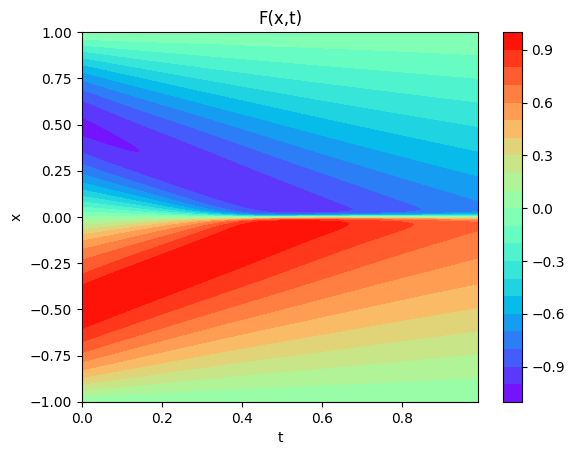

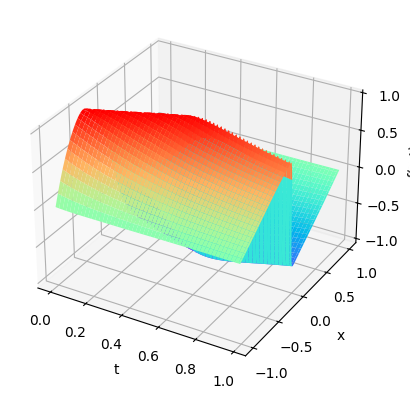

In [288]:
plot3D_Matrix(arr_x1,arr_T1,torch.from_numpy(final_pred))

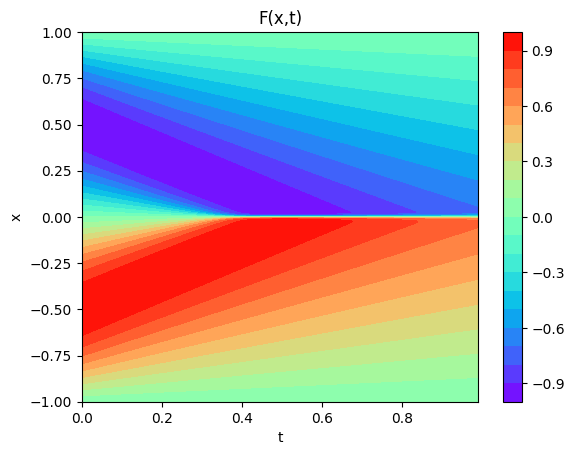

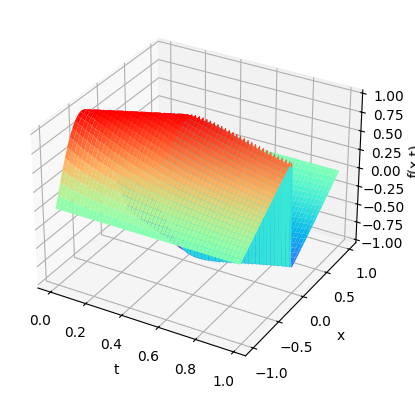

In [289]:
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol)) 

## References:


[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations. arXiv preprint arXiv:1711.10561. http://arxiv.org/pdf/1711.10561v1

[2] Lu, L., Meng, X., Mao, Z., & Karniadakis, G. E. (1907). DeepXDE: A deep learning library for solving differential equations,(2019). URL http://arxiv. org/abs/1907.04502. https://arxiv.org/abs/1907.04502

[3] Rackauckas Chris, Introduction to Scientific Machine Learning through Physics-Informed Neural Networks. https://book.sciml.ai/notes/03/

[4] Repository: Physics-Informed-Neural-Networks (PINNs).https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation

[5]  Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics Informed Deep Learning (part ii): Data-driven Discovery of Nonlinear Partial Differential Equations. arXiv preprint arXiv:1711.10566. https://arxiv.org/abs/1711.10566

[6] Repository: PPhysics-Informed Deep Learning and its Application in Computational Solid and Fluid Mechanics.https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics.

